In [2]:
%matplotlib inline

from os import listdir

import torch
import h5py, os
import numpy as np
from matplotlib import pyplot as plt
from functions import transforms as T
from functions.subsample import MaskFunc
from skimage.measure import compare_ssim 

# Functions

In [20]:
def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')
        
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

def save_reconstructions(reconstructions, out_dir):
    """
    Saves the reconstructions from a model into h5 files that is appropriate for submission
    to the leaderboard.
    Args:
        reconstructions (dict[str, np.array]): A dictionary mapping input filenames to
            corresponding reconstructions (of shape num_slices x height x width).
        out_dir (pathlib.Path): Path to the output directory where the reconstructions
            should be saved.
    """
    for fname, recons in reconstructions.items():
        subject_path = os.path.join(out_dir, fname)
        print(subject_path)
        with h5py.File(subject_path, 'w') as f:
            f.create_dataset('reconstruction', data=recons)

# Load Training Files

In [4]:
train_folder_path = 'C:\\Users\\Jonat\\Documents\\NueralData\\Train\\'

train_file = os.listdir(train_folder_path)

# Generate/Save 4AF and 8AF

In [3]:
for file in train_file:
    train_file_path = train_folder_path + file
    with h5py.File(train_file_path,  "r") as hf:
        volume_kspace = hf['kspace'][()]
    
    volume_kspace2 = T.to_tensor(volume_kspace)      # Convert from numpy array to pytorch tensor
    volume_image = T.ifft2(volume_kspace2)           # Apply Inverse Fourier Transform to get the complex image
    volume_image_abs = T.complex_abs(volume_image)   # Compute absolute value to get a real image

    # create mask function objects
    mask_func0 = MaskFunc(center_fractions=[0.08], accelerations=[4])
    mask_func1 = MaskFunc(center_fractions=[0.04], accelerations=[8])
    
    shape = np.array(volume_kspace2.shape)

    mask0 = mask_func0(shape, seed=0) # use seed here to exclude randomness  
    mask1 = mask_func1(shape, seed=0)

    masked_kspace0 = torch.where(mask0 == 0, torch.Tensor([0]), volume_kspace2) # masked kspace data with AF=4
    masked_kspace1 = torch.where(mask1 == 0, torch.Tensor([0]), volume_kspace2) # masked kspace data with AF=8

    S_Num, Ny, Nx, _ = volume_kspace2.shape
    masks0 = mask0.repeat(S_Num, Ny, 1, 1).squeeze() # masks when AF=4
    masks1 = mask1.repeat(S_Num, Ny, 1, 1).squeeze() # masks when AF=8

    sampled_image0 = T.ifft2(masked_kspace0)             # Apply Inverse Fourier Transform to get the complex image
    sampled_image_abs0 = T.complex_abs(sampled_image0)   # Compute absolute value to get a real image

    sampled_image1 = T.ifft2(masked_kspace1)             # Apply Inverse Fourier Transform to get the complex image
    sampled_image_abs1 = T.complex_abs(sampled_image1)   # Compute absolute value to get a real image

    # crop the images to the central 320x320 pixel region, as evaluation will be made based on cropped images
    cropped_gt = T.center_crop(volume_image_abs, [320, 320])
    cropped_4af = T.center_crop(sampled_image_abs0, [320, 320])
    cropped_8af = T.center_crop(sampled_image_abs1, [320, 320]) 
    
    # saving reconstructions
    fname0 = 'GrounTruth' + file 
    fname1 = '4AF' + file 
    fname2 = '8AF' + file 
    reconstructions = {fname0: cropped_gt.numpy(), fname1: cropped_4af.numpy(), fname2: cropped_8af.numpy()}
    out_dir = 'C:\\Users\\Jonat\\Documents\\NueralData\\Saved' # where you want to save your result. 
    if not (os.path.exists(out_dir)): os.makedirs(out_dir)
    save_reconstructions(reconstructions, out_dir)

    

NameError: name 'train_file' is not defined

In [27]:
from torch.utils.data import DataLoader

def get_epoch_batch(subject_id, acc, center_fract, use_seed=True):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)

    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
        
    return img_gt.squeeze(0), img_und.squeeze(0), rawdata_und.squeeze(0), masks.squeeze(0), norm

def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
    
        for fname in sorted(os.listdir(which_data_path)):
            
            subject_data_path = os.path.join(which_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
    
    return data_list

class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)

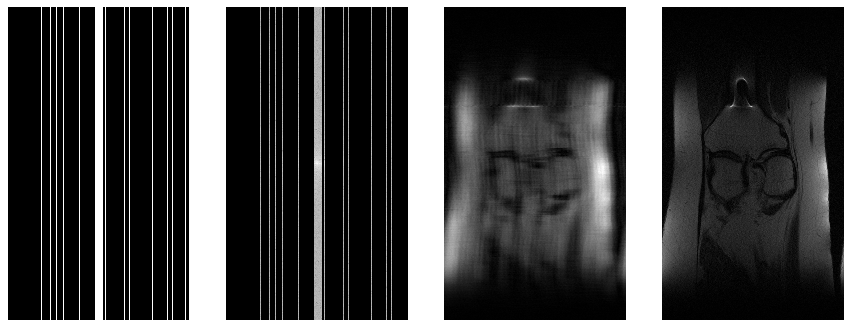

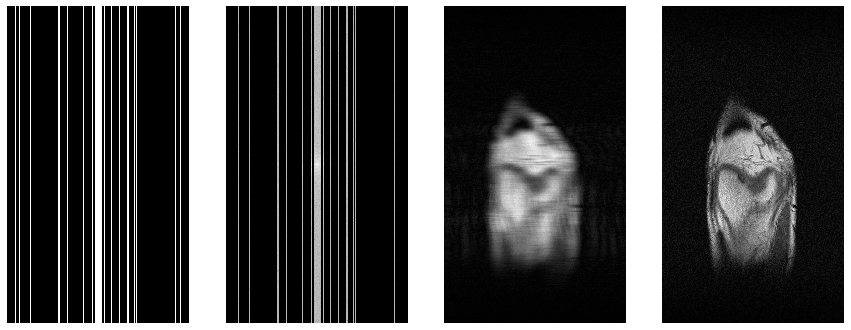

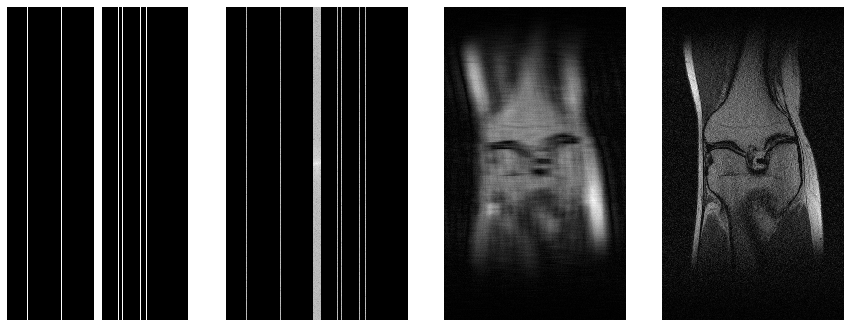

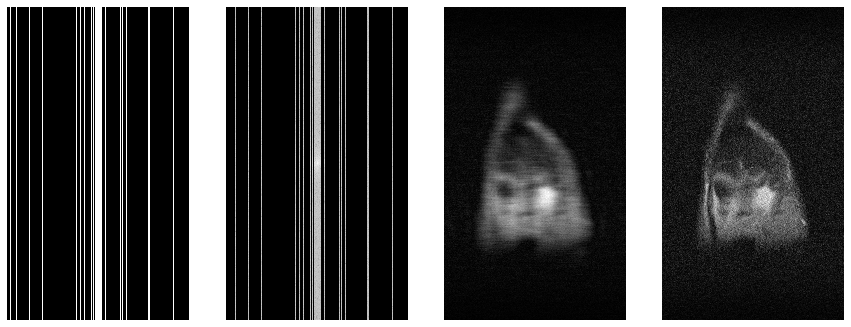

In [44]:
if __name__ == '__main__':
    data_path_train = 'C:\\Users\\Jonat\\Documents\\NueralData\\Train\\'
    data_path_val = 'C:\\Users\\Jonat\\Documents\\NueralData\\Train\\'
    data_list = load_data_path(data_path_train, data_path_val) # first load all file names, paths and slices.

    acc = 8
    cen_fract = 0.04
    seed = False # random masks for each slice 
    num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
    # create data loader for training set. It applies same to validation set as well
    train_dataset = MRIDataset(data_list['train'], acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    # changed num_workers to 0 -> avoids broken pipe error for windows dataloader
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=0)
    
    for iteration, sample in enumerate(train_loader):
        img_gt, img_und, rawdata_und, masks, norm = sample
         
        # stack different slices into a volume for visualisation
        A = masks[...,0].squeeze()
        B = torch.log(T.complex_abs(rawdata_und) + 1e-9).squeeze()
        C = T.complex_abs(img_und).squeeze()
        D = T.complex_abs(img_gt).squeeze()
        all_imgs = torch.stack([A,B,C,D], dim=0)

        # from left to right: mask, masked kspace, undersampled image, ground truth
        show_slices(all_imgs, [0, 1, 2, 3], cmap='gray')
        plt.pause(1)

        if iteration >= 3: break  # show 4 random slices